In [1]:
import os

os.environ['CRDS_PATH'] = '/home/tdewachter/crds_cache'
os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from utils import *
from scipy.signal import find_peaks_cwt
from scipy.optimize import curve_fit as cfit

ModuleNotFoundError: No module named 'utils'

In [44]:
def gaussian(x,x0,A,s):
    return A * np.exp(-(x-x0)**2 / (2*s**2))

def slitlet(x,x1,x2,x3,A1,A2,A3,s):
    return gaussian(x,x1,A1,s) + gaussian(x,x2,A2,s) + gaussian(x,x3,A3,s)

def doTheFit(x,y,peaks):
    X = np.linspace(0,len(x),100)
    coeff, err, info, msg, ier = cfit(slitlet, x, y, p0=[*peaks,*y[peaks],0.5],full_output=True)
    print(msg)
    print(coeff)
    plt.plot(X,slitlet(X,*coeff))

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000
[ 7.25242237 12.37904341 17.43584244  0.10881428  0.10906323  0.11240519
  1.65941789]


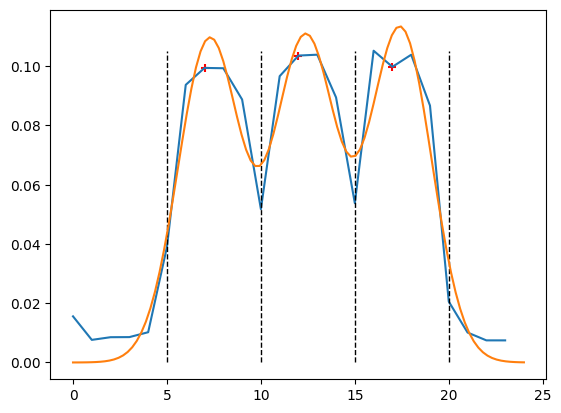

In [47]:
name = "jw01345063001_03101_00001_nrs1_srctype.fits"
multi_hdu = fits.open(name)

for i,hdu in enumerate(multi_hdu):
    if not hdu.name == 'SCI':
        continue
    hdr = hdu.header
    data = np.ma.array(hdu.data, mask=np.isnan(hdu.data))

    shutter_id = WhichShutterOpen(hdr)
    if shutter_id == None:
        continue

    # Get vertical cross section by summing horizontally
    horiz_sum = np.mean(data,axis=1)

    # Determine 3 maxima for 3 slits
    peaks = []
    j = 2
    while not len(peaks) == 3:
        if j > 6:
            break
        peaks = find_peaks_cwt(horiz_sum,j)
        j += 1
    if not len(peaks) == 3:
        continue

    peaks[1:] -=1
    
    # Cut horizontally at midpoint between maxima -> 3 strips
    slice_indices = getPeakSlice(peaks,0,len(horiz_sum))
    
    plt.figure()
    #horiz_sum -= horiz_sum.min()
    plt.plot(horiz_sum)
    plt.scatter(peaks,horiz_sum[peaks],marker='+',color="r")
    plt.vlines([5,10,15,20],0,horiz_sum.max(),color='k',linestyle='dashed',linewidth=1)
    
    doTheFit(range(len(horiz_sum)),horiz_sum,peaks)
    
    
    
    break
    
    # Get 2 background strips
    #TODO : Support for different height strips
    src = data[slice_indices[shutter_id][0]:slice_indices[shutter_id][1],:]
    bkg1 = data[slice_indices[shutter_id-1][0]:slice_indices[shutter_id-1][1],:]
    bkg2 = data[slice_indices[shutter_id-2][0]:slice_indices[shutter_id-2][1],:]


    # Determine non background sources : sudden spikes, high correlation with source strip -> flag pixels
    # TODO : Better background detection
    threshold = 0.3
    mask1 = bkg1 > bkg1.min() + (bkg1.max() - bkg1.min())*threshold
    mask2 = bkg2 > bkg2.min() + (bkg2.max() - bkg2.min())*threshold

    bkg1_keep = np.ma.array(bkg1,mask=mask1,fill_value=np.nan)
    bkg2_keep = np.ma.array(bkg2,mask=mask2,fill_value=np.nan)

    height = min(bkg1_keep.shape[0],bkg2_keep.shape[0])

    bkg_master = np.ma.dstack((bkg1_keep[:height,:],bkg2_keep[:height,:])).mean(axis=2)
    mask_master = np.ma.getmask(bkg_master)



    # Remove pixels + interpolate on a given strip (ignore source strip)
    non_nan = np.where(np.logical_not(mask_master))
    x = non_nan[0]
    y = non_nan[1]
    z = bkg_master[non_nan]

    interp = NNExtrapolation(np.c_[x, y], z)

    X = np.arange(bkg_master.shape[0])
    Y = np.arange(bkg_master.shape[1])
    YY,XX = np.meshgrid(Y,X)
    bkg_interp = interp(XX,YY)

    """
    plt.figure()

    plt.subplot(4,1,1)
    plt.title("Background")
    plt.imshow(bkg1[:height,:],interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,2)
    plt.title("Master Background")
    plt.imshow(bkg_master,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,3)
    plt.title("Nearest Neighbour")
    plt.imshow(bkg_interp,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())
    plt.subplot(4,1,4)
    plt.title("Inverse Distance Weighting")
    interp = IDWExtrapolation(np.c_[x,y], z,power = 3)
    bkg_interp = interp(XX,YY)
    plt.imshow(bkg_interp,interpolation='none',vmin=bkg1.min(),vmax=bkg1.max())

    plt.savefig(str(i)+".png")
    plt.close()
    """
multi_hdu.close()
plt.show(block=False)

In [55]:
data = np.zeros((10,10))
data[:,:] = np.nan
data[2:4,:] = 1

non_nan = np.where(np.logical_not(np.isnan(data)))
print(data)
print(non_nan)

print(data[non_nan])

[[nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]]
(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]), array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]))
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


[[0.023165037855505943 0.023830391466617584 0.026531599462032318 ...
  0.009749867022037506 0.0046244733966887 0.0025719606783241034]
 [0.004217890556901693 0.0005889603053219616 0.0012021600268781185 ...
  -0.0055128904059529305 0.00039817692595534027 0.0024287996347993612]
 [0.012835645116865635 0.011768750846385956 0.003625900251790881 ...
  0.007343785371631384 0.011449532583355904 0.005021176300942898]
 ...
 [0.008031260222196579 0.0025799537543207407 0.010951473377645016 ...
  0.0012145200744271278 0.016651367768645287 0.006200246978551149]
 [0.006249620113521814 0.006562943570315838 0.006834028288722038 ...
  0.0009985796641558409 0.009393622167408466 0.006036053877323866]
 [-0.0029309983365237713 0.00485641323029995 0.0065965717658400536 ...
  0.003852694761008024 -0.001271505723707378 0.004323776811361313]]


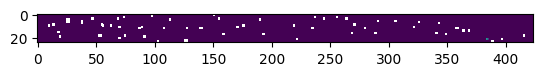

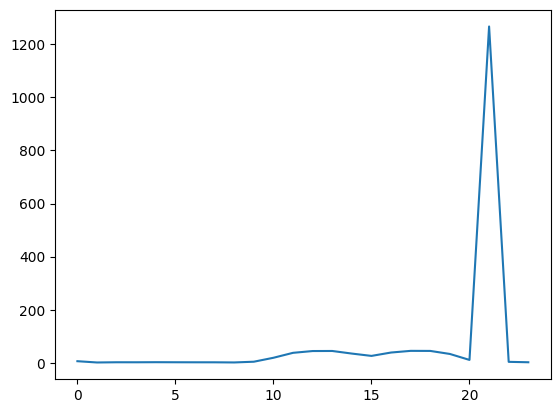

In [64]:
multi_hdu = fits.open(name)
data = multi_hdu[673].data
data = np.ma.array(data,mask=np.isnan(data))
print(data)
plt.figure()
plt.imshow(data)
plt.show()
x = data.sum(axis=1)
plt.figure()
plt.plot(x)
multi_hdu.close()

In [32]:
import matplotlib
matplotlib.rcParams['interactive'] == True

name = "jw01345063001_03101_00001_nrs1_srctype.fits"

multi_hdu = fits.open(name)


def f(x,a,b,c,p):
    return (a*x+b)**p + c

datas = np.array([])
for hdu in multi_hdu:
    if not hdu.name == 'SCI':
        continue
    data = np.ma.array(hdu.data, mask=np.isnan(hdu.data),fill_value=np.nan)
    data = data / data.max()
    data[data < 0] = np.nan
    datas = np.append(datas,data.ravel())
    
datas = datas[np.isfinite(datas)]

0.06717774271965027
0.7000000697079307


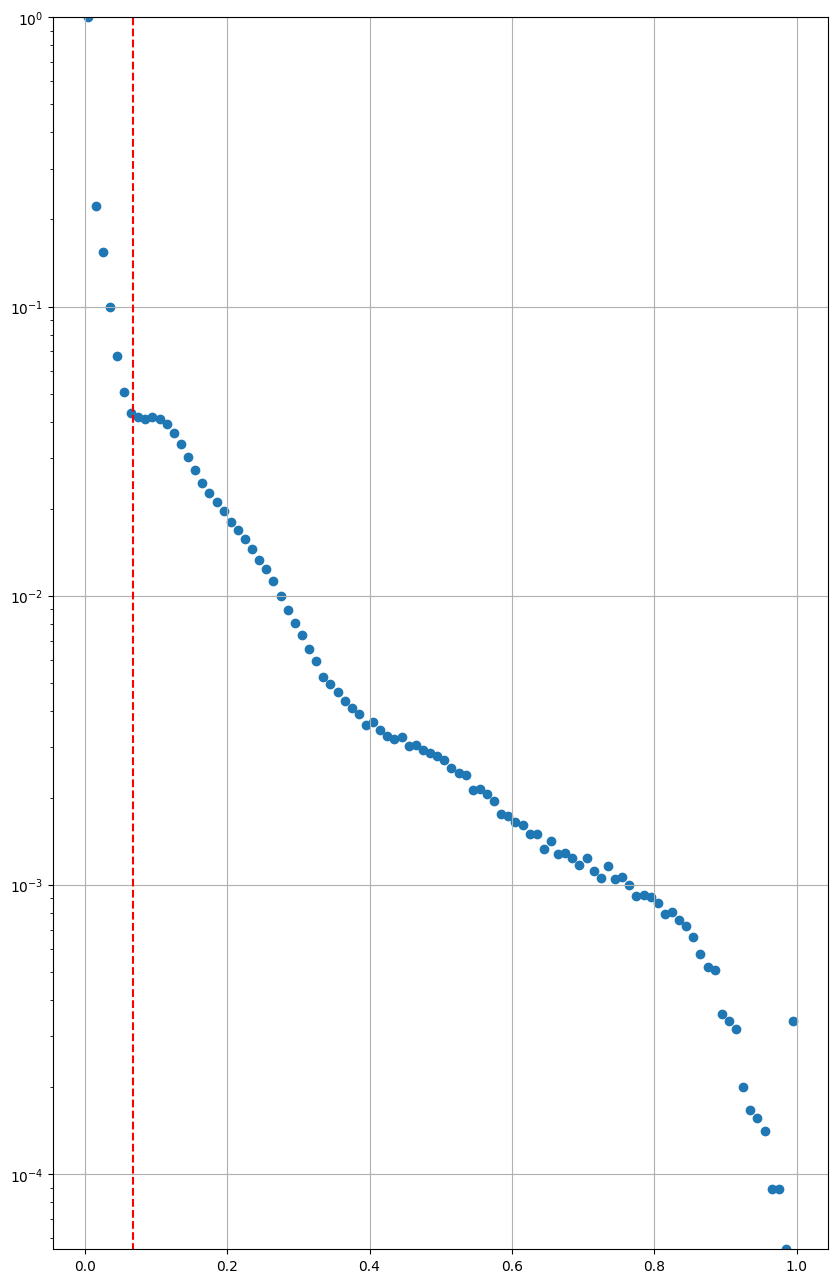

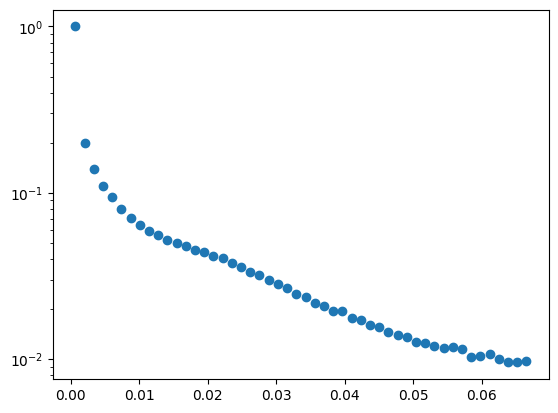

In [280]:
plt.figure(figsize=(10,16))
hist, bins = np.histogram(datas,bins=100)
bins = (bins[:-1] + bins[1:])/2
hist = hist / hist.max()
df = np.gradient(np.log(hist),bins[1]-bins[0])
plt.scatter(bins,hist)
plt.grid(True)

plt.yscale("log")
plt.ylim(np.min(hist),np.max(hist))
print(q)
q=np.quantile(datas,0.7)
print(len(datas[datas<q])/len(datas))
plt.vlines(q,0,np.max(hist),color='r',linestyle='dashed')
plt.show()

plt.figure()

hist, bins = np.histogram(datas[datas<q],bins=50)
bins = (bins[:-1] + bins[1:])/2
hist = hist / hist.max()
plt.scatter(bins,hist)
plt.yscale('log')
plt.show()

39.0 0 407


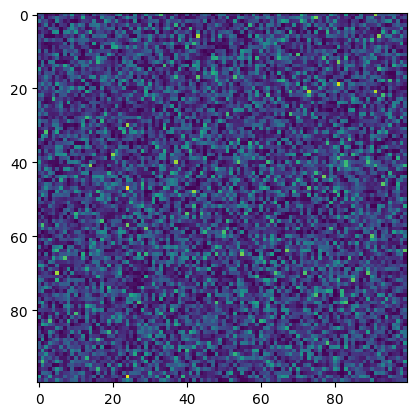

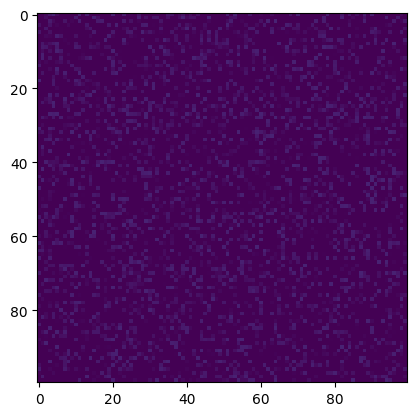

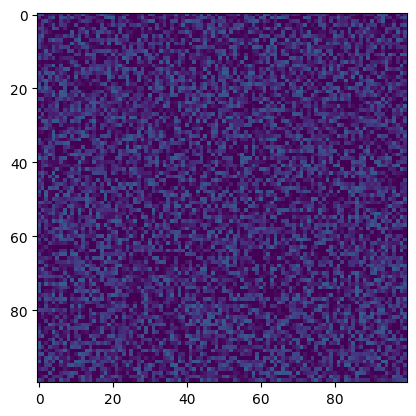

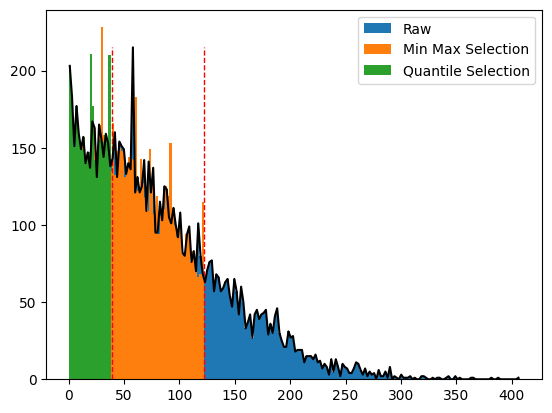

In [182]:
data = np.abs(np.random.poisson(10000,(100,100))-10000)

q = np.quantile(data,0.3)
print(q,data.min(),data.max())

x,y = np.where((data < q))

plt.figure()
plt.imshow(data)
plt.show()

zeros = np.zeros_like(data)
zeros[:,:] = -1
zeros[x,y] = data[x,y]

plt.figure()
plt.imshow(zeros,vmax=np.max(data))
plt.show()

n = 200

hist, bins = np.histogram(data.ravel(),bins=n)
bins = (bins[1:] + bins[:-1])/2

a = 0.3
x,y = np.where((data <  a*data.max()))
zeros_mm = np.zeros_like(data)
zeros_mm[:,:] = -1
zeros_mm[x,y] = data[x,y]

plt.figure()
plt.imshow(zeros_mm,vmax=np.max(data))
plt.show()

plt.figure()
plt.hist(data.ravel(),bins = n,label="Raw")
spacing = (data.max() - data.min())/n
plt.hist(zeros_mm[zeros_mm > -1].ravel(), bins = int((zeros_mm.max())/spacing), label="Min Max Selection")
plt.hist(zeros[zeros > -1].ravel(),bins = int((zeros.max())/spacing),label="Quantile Selection")
plt.vlines(q,0,np.max(hist),color='r',linestyle='dashed',linewidth=1)
plt.vlines(a*data.max(),0,np.max(hist),color='r',linestyle='dashed',linewidth=1)

plt.plot(bins,hist,color='k')

plt.legend()
plt.show()

In [187]:
def IDWExtrapolation(xy, ui, power=1):
    """
    Rough implementation of the Inverse Distance Weighting algorithm

    Parameters
    ----------
    xy : ndarray, shape (npoints, ndim)
        Coordinates of data points
    ui : ndarray, shape (npoints)
        Values at data points

    Returns
    -------
    func : callable
    """
    x = xy[:, 0]
    y = xy[:, 1]

    def new_f(xx,yy):

        xy_ravel = np.column_stack((xx.ravel(),yy.ravel()))
        x_ravel = xy_ravel[:, 0]
        y_ravel = xy_ravel[:, 1]

        X1, X2 = np.meshgrid(x,x_ravel)
        Y1, Y2 = np.meshgrid(y,y_ravel)

        d = ((X1-X2)**2 + (Y1-Y2)**2).T

        w = d**(-power/2)

        w_ui_sum = ui[:, None]*w
        w_ui_sum = w_ui_sum.sum(axis=0)

        wsum = w.sum(axis=0)

        result = w_ui_sum / wsum
        result = result.reshape(np.shape(xx))
        result[x,y] = ui

        return result

    return new_f




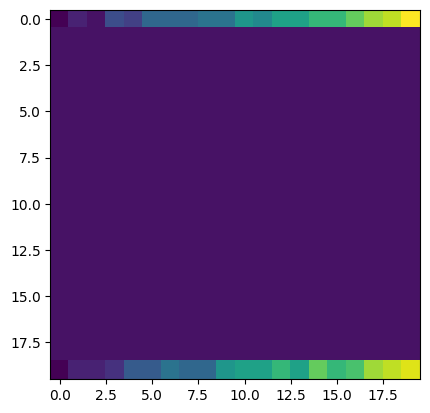

/tmp/ipykernel_6248/3440803820.py:30: RuntimeWarning: divide by zero encountered in power
  w = d**(-power/2)
/tmp/ipykernel_6248/3440803820.py:37: RuntimeWarning: invalid value encountered in divide
  result = w_ui_sum / wsum


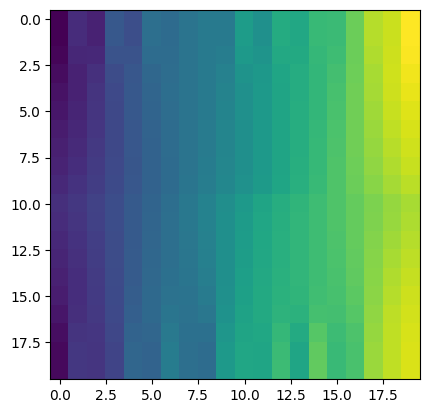

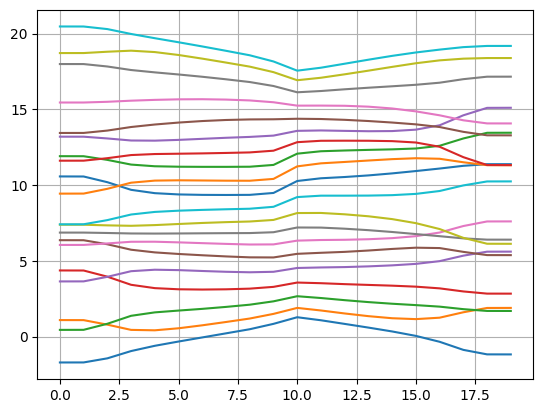

[-0.23169992  1.21361055  1.79820544  3.37754973  4.5412978   5.63892136
  6.47223051  6.82263672  7.39942754  8.84034498 10.30456419 10.79160013
 12.02344324 12.20224974 13.56016973 13.94632933 15.17097503 16.992351
 18.10894205 19.01476072]


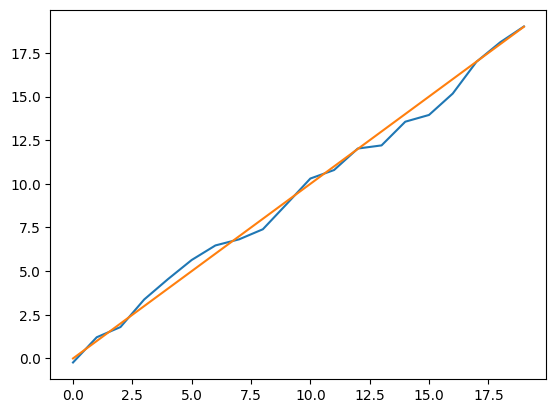

In [279]:
x = np.zeros(20,dtype=np.int8)
y = np.arange(20)
x = np.append(x,np.ones(20,dtype=np.int8)*19)
y = np.append(y,np.arange(20))
ui = np.append(np.arange(20),np.arange(20)) + np.random.random(40)*4 - 2


Y,X = np.meshgrid(np.arange(20),np.arange(20))
Z = np.zeros_like(X)
Z[x,y] = ui

plt.figure()
plt.imshow(Z)
plt.show()

interp = IDWExtrapolation(np.c_[x,y],ui,power=20)

z = interp(X,Y)

plt.figure()
plt.imshow(z)
plt.show()

plt.figure()
plt.plot(z)
plt.grid()
plt.show()

print(z.mean(axis=0))

plt.figure()
plt.plot(z.mean(axis=0),label="Interpolated")
plt.plot(np.arange(20))

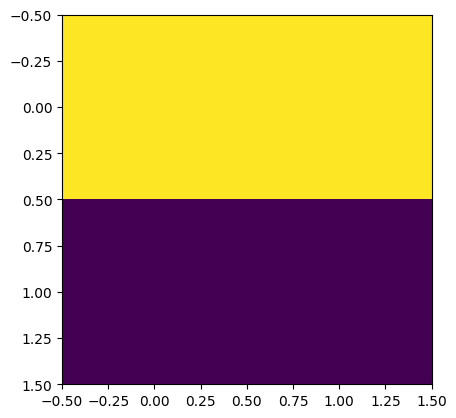

In [281]:
plt.figure()
plt.imshow(np.array([[True,True],[False,False]]))
plt.show()

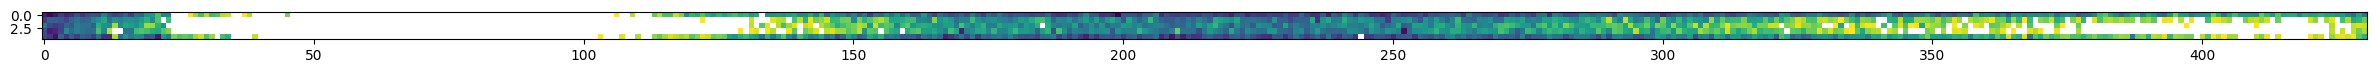

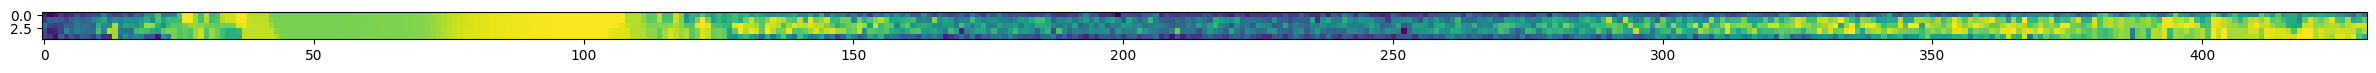

In [36]:
data = np.load("test-data.npy")
mask = np.load("test-mask.npy")

data = np.ma.array(data,mask=mask,fill_value=np.nan)

plt.figure(figsize=(30,4))
plt.imshow(data)
plt.show()

non_nan = np.where(~mask)
x = non_nan[0]
y = non_nan[1]
z = data[non_nan]
z = np.ma.getdata(z)

interp = IDWExtrapolation(np.c_[x, y], z, power=10)
X = np.arange(data.shape[0])
Y = np.arange(data.shape[1])
YY,XX = np.meshgrid(Y,X)
img = interp(XX,YY)


plt.figure(figsize=(30,4))
plt.imshow(img,vmax=np.max(data),vmin=np.min(data))
plt.show()

In [34]:
def IDWExtrapolation(xy, ui, power=1):
    x = xy[:, 0]
    y = xy[:, 1]
    def new_f(xx,yy):

        xy_ravel = np.column_stack((xx.ravel(),yy.ravel()))
        x_ravel = xy_ravel[:, 0]
        y_ravel = xy_ravel[:, 1]
        

        X1, X2 = np.meshgrid(x,x_ravel)
        Y1, Y2 = np.meshgrid(y,y_ravel)

        d = ((X1-X2)**2 + (Y1-Y2)**2).T

        w = np.zeros_like(d,dtype=float)
        

        w[d>0] = d[d>0]**(-power/2)
        

        w_ui_sum = ui[:, None]*w
        w_ui_sum = w_ui_sum.sum(axis=0)

        wsum = w.sum(axis=0)

        result = w_ui_sum / wsum
        result = result.reshape(np.shape(xx))

        result[x,y] = ui
        
        return result

    return new_f

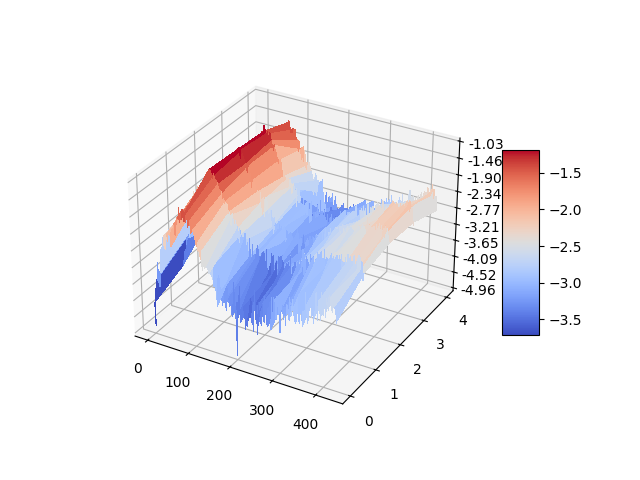

In [3]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D

data = np.log(np.load("test-data.npy"))
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(data.shape[1])
Y = np.arange(data.shape[0])
X, Y = np.meshgrid(X, Y)
Z = data

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [18]:
import pandas as pd

In [36]:
doubleslits = pd.read_csv("slits_with_double_object.dat",sep=",")
print(doubleslits)

    Pointing Disperser  Central_target  Companion
0          4     prism             386      35134
1          4     prism             757      19565
2          4     prism            5674      22842
3          4     prism           19960       9743
4          4     prism           17699       8656
5          4     Mgrat             386      35134
6          4     Mgrat             613      22310
7          5     prism            9141      30152
8          5     Mgrat              76      13348
9          7     prism           10685      24686
10         7     prism            2962      28042
11         8     prism           22247      14589
12         8     prism           37988      37993
13         8     prism            8997      37597
14         8     prism            1378       1381
15         8     prism           16772      40571
16         8     Mgrat           37597       8997
17         9     prism            3765       8735
18         9     prism            3929       3928


In [7]:
from astroquery.mast import Observations as OBS
obs_table = OBS.query_criteria(
	dataRights = ["public"],
	provenance_name = ["CALJWST"], 
	intentType = ["science"],
	obs_collection = ["JWST"],
	instrument_name = ["NIRSPEC/MSA"],
	obs_title = ['Spectroscopic follow-up of ultra-high-z candidates in CEERS: Characterizing true z > 12 galaxies and z~4-7 interlopers in preparation for JWST Cycle 2', 
					'The Cosmic Evolution Early Release Science (CEERS) Survey free'],
	filters = ["CLEAR;PRISM"]
	)

In [62]:
obs_id = obs_table["obs_id"]
ct = doubleslits["Central_target"]


def find_corresponding_entry(entry):
    entry = [*str(entry)]
    while len(entry) < 5:
        entry.insert(0, '0')
    entry = "".join(entry)
    for _ in range(len(obs_id)):
        obs = obs_id[_]
        if f"{entry}_nirspec" in obs:
            return obs_table["obsid"][_],obs_table["obs_id"][_]
    


result = ct.apply(find_corresponding_entry)
print(result)


data_products = OBS.get_product_list(str(178725723))
print(data_products)

0     (128929299, jw01345-o062_s00386_nirspec_clear-...
1     (128929584, jw01345-o062_s00757_nirspec_clear-...
2     (178732063, jw01345-o062_s05674_nirspec_clear-...
3     (178733961, jw01345-o062_s19960_nirspec_clear-...
4     (128929251, jw01345-o062_s17699_nirspec_clear-...
5     (128929299, jw01345-o062_s00386_nirspec_clear-...
6                                                  None
7     (178725768, jw01345-o063_s09141_nirspec_clear-...
8     (107451180, jw01345-o065_s00076_nirspec_clear-...
9     (107451106, jw01345-o065_s10685_nirspec_clear-...
10    (107451363, jw01345-o065_s02962_nirspec_clear-...
11    (178724889, jw01345-o067_s22247_nirspec_clear-...
12    (178725997, jw01345-o067_s37988_nirspec_clear-...
13    (178725723, jw01345-o067_s08997_nirspec_clear-...
14    (108152288, jw01345-o067_s01378_nirspec_clear-...
15    (108152141, jw01345-o067_s16772_nirspec_clear-...
16                                                 None
17    (185191265, jw01345-o070_s03765_nirspec_cl

In [69]:
print(obs_table.info())
print(obs_table["target_name"])

<Table masked=True length=3880>
         name          dtype  n_bad
--------------------- ------- -----
           intentType    str7     0
       obs_collection    str4     0
      provenance_name    str7     0
      instrument_name   str11     0
              project    str4     0
              filters   str11     0
    wavelength_region    str8     0
          target_name   str29     0
target_classification    str1  3880
               obs_id   str39     0
                 s_ra float64     0
                s_dec float64     0
     dataproduct_type    str8     0
          proposal_pi   str22     0
          calib_level   int64     0
                t_min float64     0
                t_max float64     0
            t_exptime float64     0
               em_min float64     0
               em_max float64     0
            obs_title  str150     0
        t_obs_release float64     0
          proposal_id    str4     0
        proposal_type    str3     0
      sequence_number   int64  3

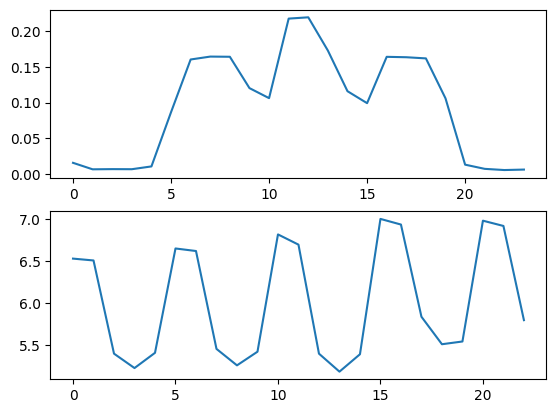

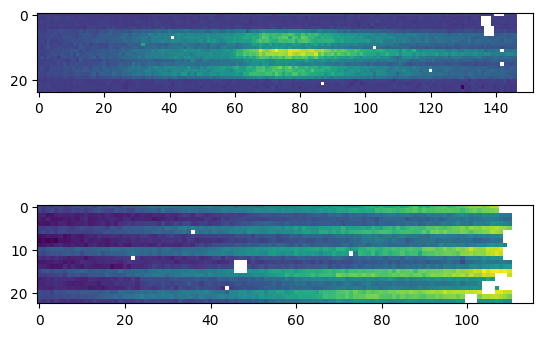

In [2]:
with fits.open("jw01345072001_03101_00001_nrs1_srctype.fits") as hdul:
    hdu = hdul["SCI",5]
    y_bad = np.nanmean(hdu.data,axis=1)
    data_bad = hdu.data
    hdr = hdul.header
    
    
with fits.open("jw01345063001_03101_00001_nrs1_srctype.fits") as hdul:
    hdu = hdul["SCI",10]
    y_good = np.nanmean(hdu.data,axis=1)
    data_good = hdu.data
    
    
plt.figure()
plt.subplot(2,1,1)
plt.plot(y_good)
plt.subplot(2,1,2)
plt.plot(y_bad)
plt.show()

plt.figure()
plt.subplot(2,1,1)
plt.imshow(data_good)
plt.subplot(2,1,2)
plt.imshow(data_bad)
plt.show()

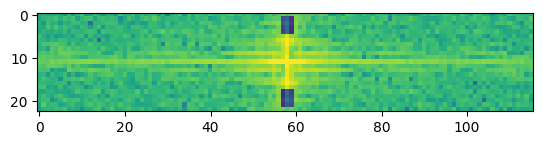

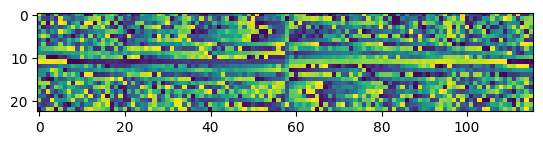

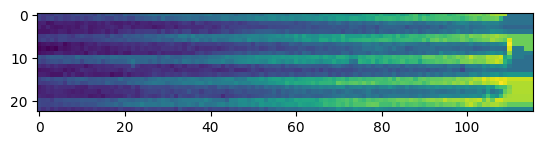

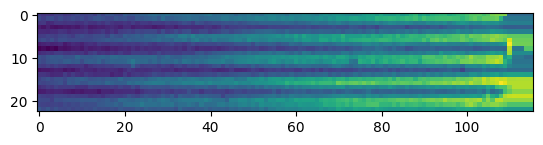

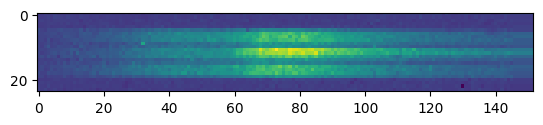

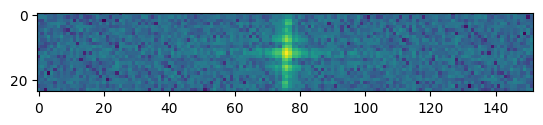

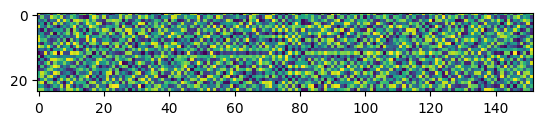

In [68]:
from matplotlib.colors import LogNorm

def NNExtrapolation(xy, z):
    x = xy[:, 0]
    y = xy[:, 1]
    f = CT(xy, z)

    # this inner function will be returned to a user
    def new_f(xx, yy):
        # evaluate the CT interpolator. Out-of-bounds values are nan.
        zz = f(xx, yy)
        nans = np.isnan(zz)

        if nans.any():
            # for each nan point, find its nearest neighbor
            inds = np.argmin(
                (x[:, None] - xx[nans])**2 +
                (y[:, None] - yy[nans])**2
                , axis=0)
            # ... and use its value
            zz[nans] = z[inds]
        return zz

    return new_f


non_nan = np.where(~np.isnan(data_bad))
x = non_nan[0]
y = non_nan[1]
z = data_bad[non_nan]
z = np.ma.getdata(z)
interp = NNExtrapolation(np.c_[x,y],z)
X = np.arange(data_bad.shape[0])
Y = np.arange(data_bad.shape[1])
YY,XX = np.meshgrid(Y,X)
data = interp(XX,YY)


TF = np.fft.fft2(data)
TF = np.fft.fftshift(TF)
TF[1:5,57:60] *= 0.001
TF[18:22,57:60] *= 0.001

plt.figure()
plt.imshow(np.abs(TF),norm=LogNorm(vmin=0.002,vmax=343))
plt.show()
plt.figure()
plt.imshow(np.angle(TF))
plt.show()

plt.figure()
plt.imshow(data)
plt.show()

data = np.fft.ifftshift(TF)
data = np.fft.ifft2(TF)

plt.figure()
plt.imshow(abs(data))
plt.show()




non_nan = np.where(~np.isnan(data_good))
x = non_nan[0]
y = non_nan[1]
z = data_good[non_nan]
z = np.ma.getdata(z)
interp = NNExtrapolation(np.c_[x,y],z)
X = np.arange(data_good.shape[0])
Y = np.arange(data_good.shape[1])
YY,XX = np.meshgrid(Y,X)
data = interp(XX,YY)

plt.figure()
plt.imshow(data)
plt.show()

TF = np.fft.fft2(data)
TF = np.fft.fftshift(TF)

plt.figure()
plt.imshow(np.abs(TF),norm=LogNorm())
plt.show()
plt.figure()
plt.imshow(np.angle(TF))
plt.show()

In [42]:
print(TF.min(),TF.max())

(-162.3361870833351+0.1881366227521788j) (343.67008169234+0j)


In [19]:
import pandas as pd
srcid1 = []
srcid2 = []
sltname = []

with fits.open("jw01345070001_05101_00003_nrs1_bkg.fits") as hdul2:
    with fits.open("jw01345070001_05101_00001_nrs1_bkg.fits") as hdul1:
        for i,hdu in enumerate(hdul1):
            if not (hdu.name == "SCI"):
                continue
            hdr1 = hdu.header
            hdr2 = hdul2[i].header

            srcid1.append(hdr1["SOURCEID"])
            srcid2.append(hdr2["SOURCEID"])
            sltname.append(hdr1["SLTNAME"])
            
dic = {"SOURCEID1" : srcid1,
       "SOURCEID2" : srcid2,
       "SLTNAME" : sltname
      }

df = pd.DataFrame(dic)

In [24]:
print(df)

     SOURCEID1  SOURCEID2 SLTNAME
0         -247      45055     106
1         -251       -251     111
2         -252       -252     113
3         -255       -255     116
4         -258      45057     119
..         ...        ...     ...
187       -387      45124     315
188       -388      45125     316
189       -389       -389     317
190       -391       -391     319
191       -392       -392     320

[192 rows x 3 columns]


In [48]:
import json
with open("jw01345-o072_20230831t181155_spec3_00001_asn.json","r") as asn:
    data = json.load(asn)
 
    not_science = []
    for i in range(len(data["products"][0]["members"])):
        data["products"][0]["members"][i]["expname"] = data["products"][0]["members"][i]["expname"].replace("_cal","_bkg")
        if not data["products"][0]["members"][i]["exptype"] == "science":
            not_science.append(i)
        
    # Starting from the end in order to keep the values at the same index
    for i in not_science[::-1]:
        del data["products"][0]["members"][i]  
  
with open("jw01345-o072_20230831t181155_spec3_00001_asn.json","w") as asn:
    json.dump(data,asn,indent=4)

In [2]:
import stdatamodels.jwst.datamodels as dm
from jwst.wavecorr import WavecorrStep
from jwst.flatfield import FlatFieldStep
from jwst.pathloss import PathLossStep
from jwst.barshadow import BarShadowStep
from jwst.photom import PhotomStep
from jwst.pixel_replace import PixelReplaceStep
from jwst.resample import ResampleSpecStep
from jwst.extract_1d import Extract1dStep

bkg = "jw01345070001_03101_00002_nrs1_bkg.fits"
print(bkg)
calibrated = WavecorrStep.call(bkg)
print(calibrated)
print("a")
calibrated = FlatFieldStep.call(calibrated)
calibrated = PathLossStep.call(calibrated)
calibrated = BarShadowStep.call(calibrated)
calibrated = PhotomStep.call(calibrated,output_dir=path,save_results=True)
calibrated = PixelReplaceStep.call(calibrated)
calibrated = ResampleSpecStep.call(calibrated,output_dir=path,save_results=True)
calibrated = Extract1dStep.call(calibrated,output_dir=path,save_results=True)

jw01345070001_03101_00002_nrs1_bkg.fits


2024-04-23 12:17:26,667 - CRDS - INFO -  Fetching  /home/tdewachter/crds_cache/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 189 files) (0 / 703.0 K bytes)
Traceback (most recent call last):
  File "/home/tim/anaconda3/envs/jwst_latest/lib/python3.11/site-packages/crds/core/heavy_client.py", line 353, in local_bestrefs
    return hv_best_references(context, parameters, reftypes)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tim/anaconda3/envs/jwst_latest/lib/python3.11/site-packages/crds/core/heavy_client.py", line 373, in hv_best_references
    ctx = get_symbolic_mapping(context_file, cached=True)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tim/anaconda3/envs/jwst_latest/lib/python3.11/site-packages/crds/core/heavy_client.py", line 676, in get_symbolic_mapping
    return get_pickled_mapping(   # reviewed
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/tim/anaconda3/envs/jwst_latest/lib/python3.11/si

CrdsDownloadError: Failed caching mapping files: Error fetching data for 'jwst_system_datalvl_0002.rmap' at CRDS server 'https://jwst-crds.stsci.edu' with mode 'http' : [Errno 13] Permission denied: '/home/tdewachter'

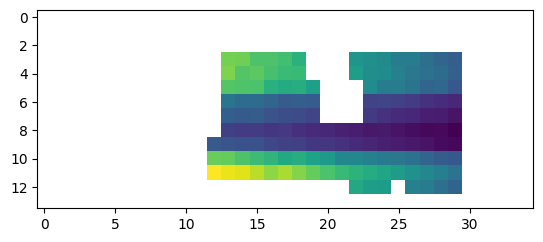

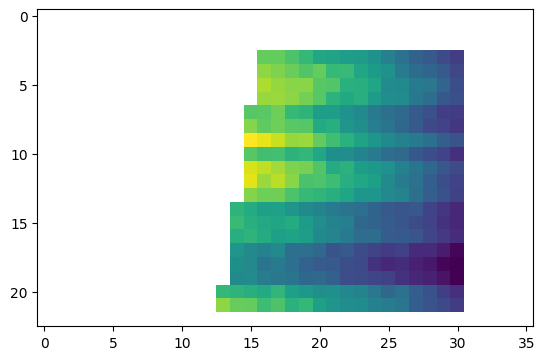

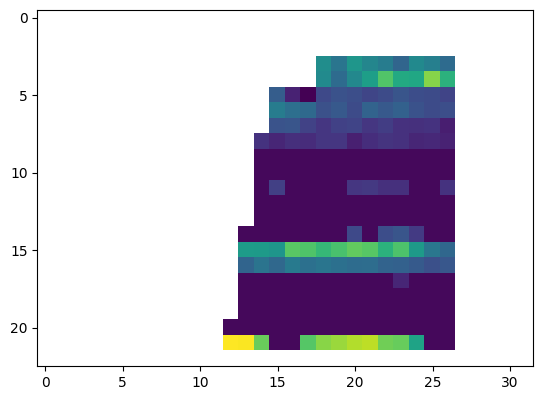

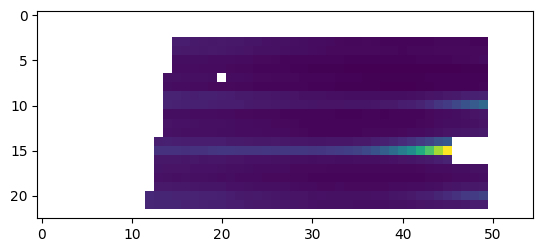

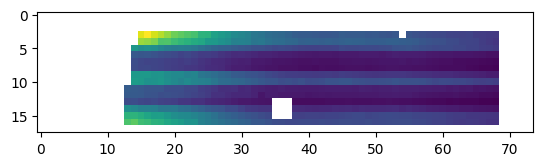

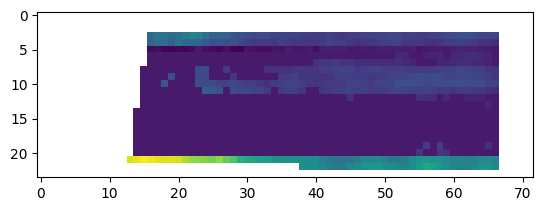

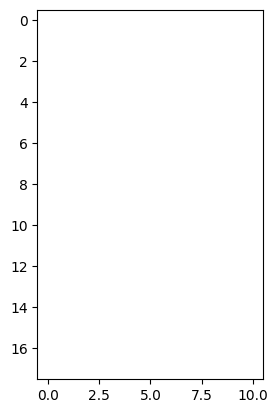

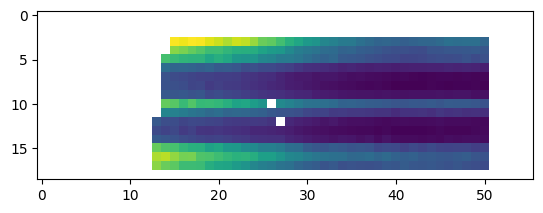

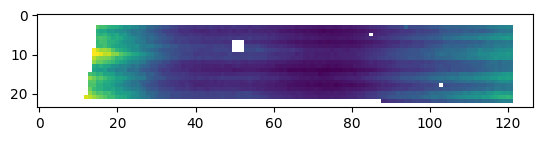

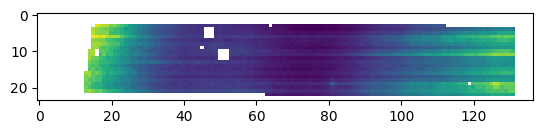

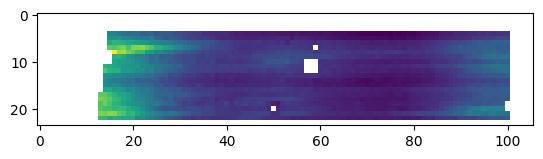

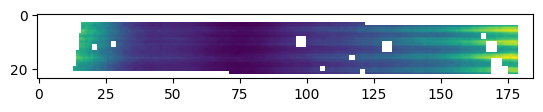

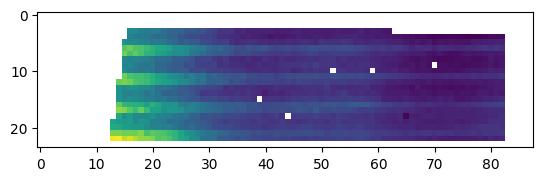

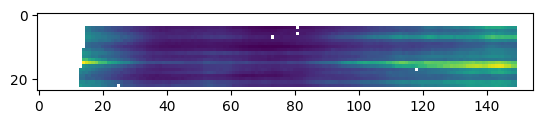

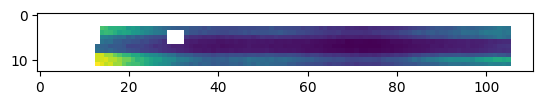

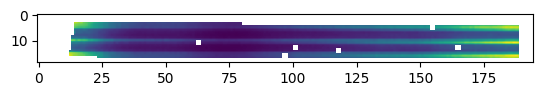

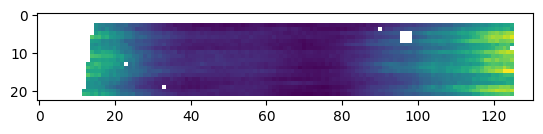

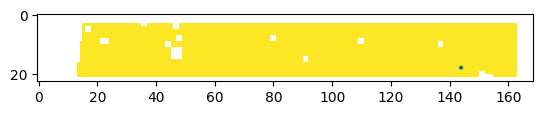

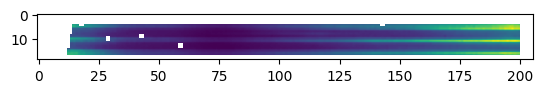

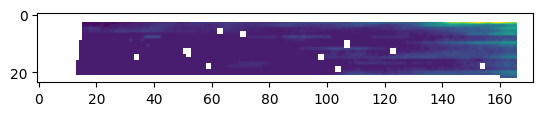

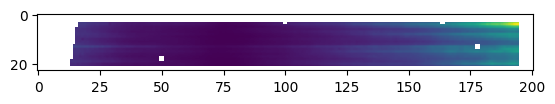

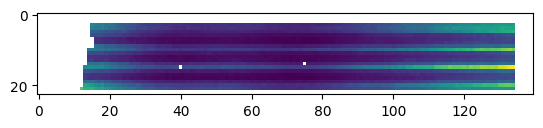

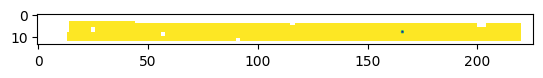

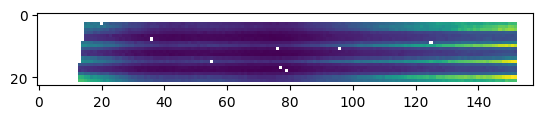

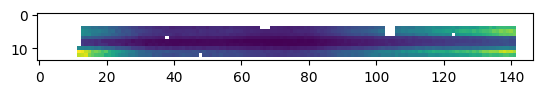

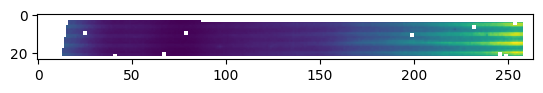

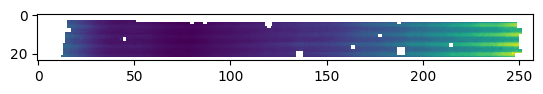

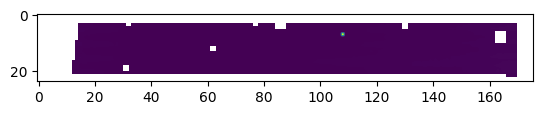

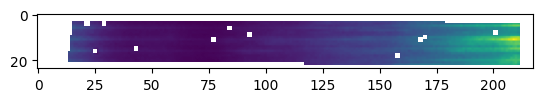

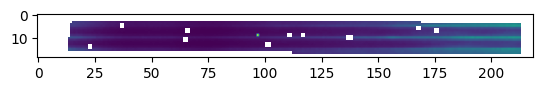

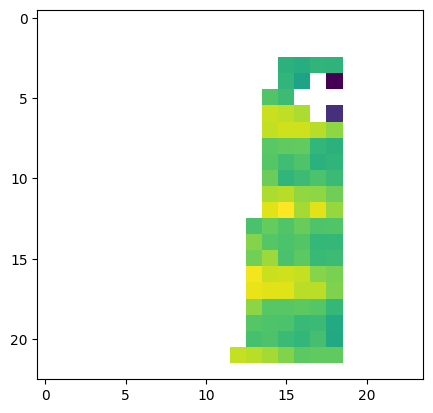

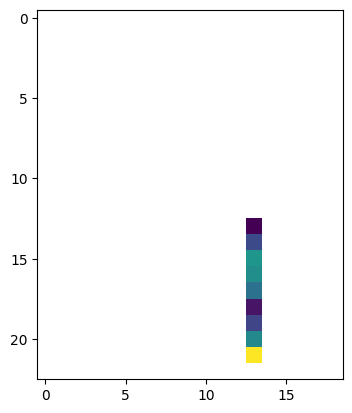

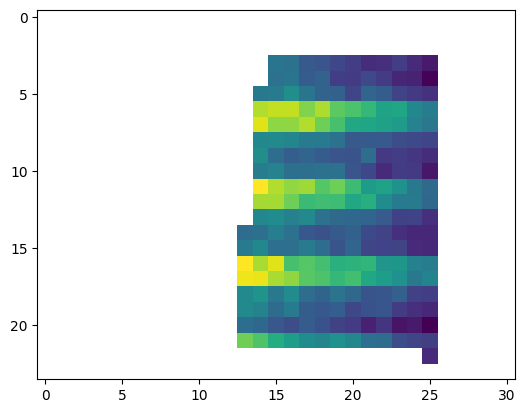

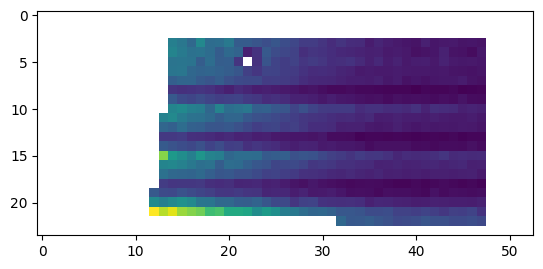

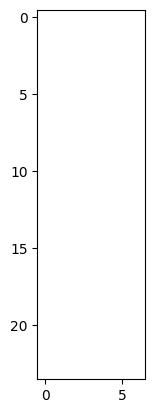

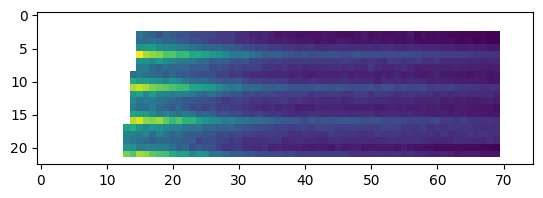

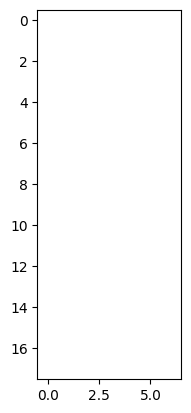

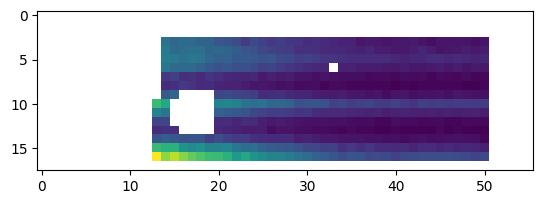

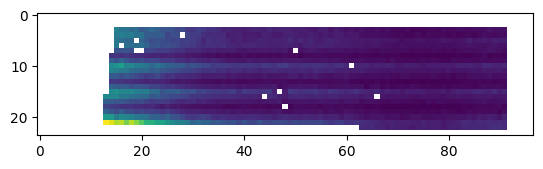

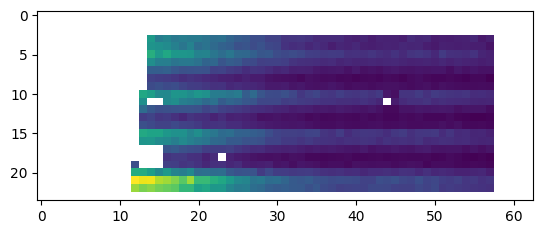

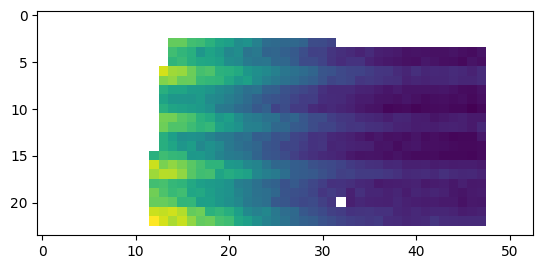

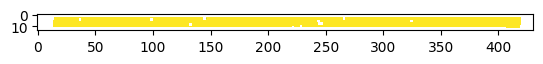

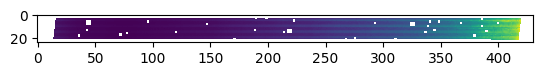

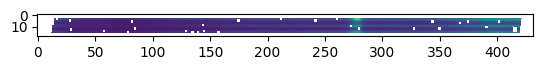

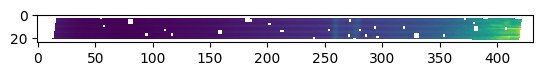

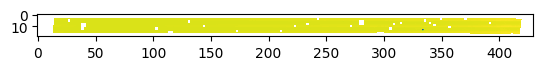

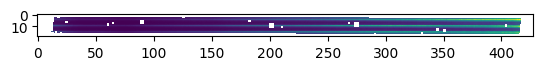

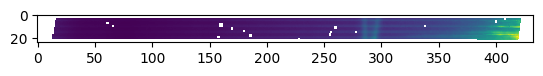

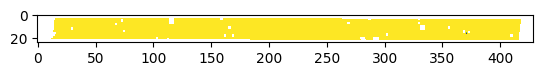

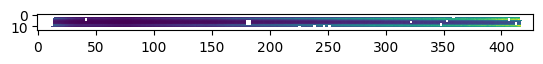

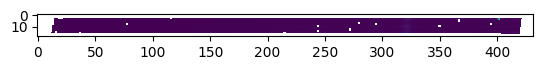

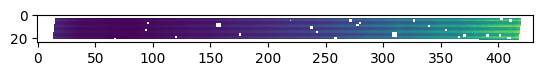

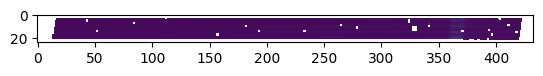

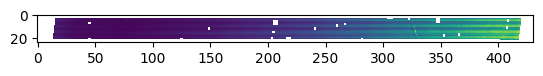

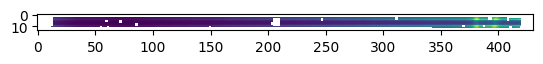

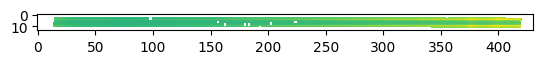

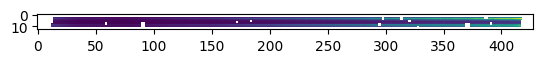

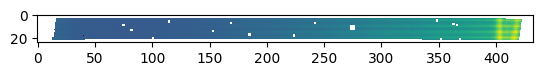

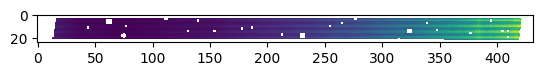

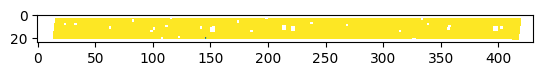

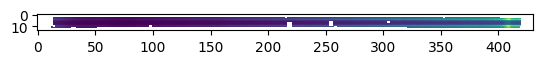

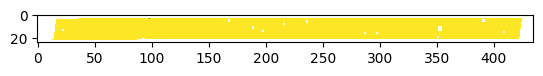

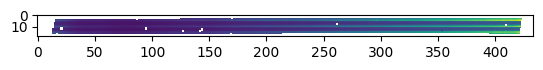

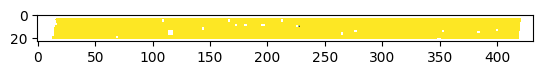

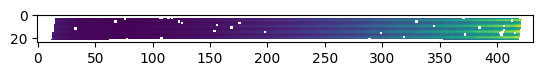

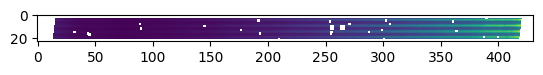

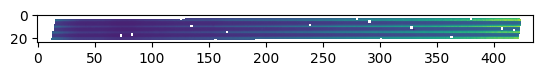

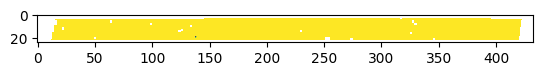

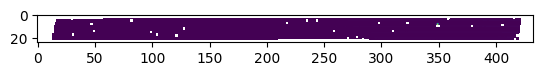

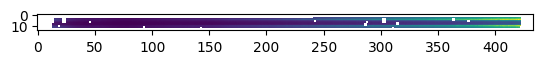

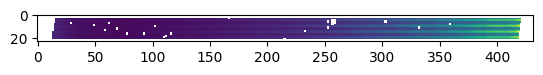

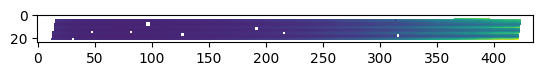

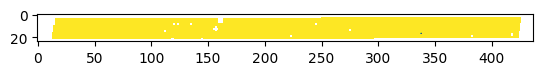

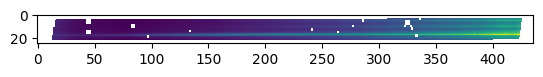

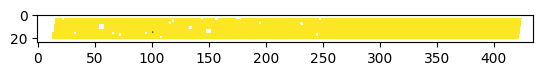

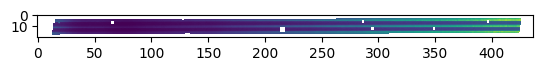

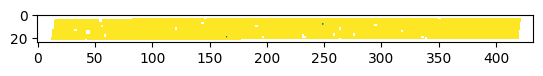

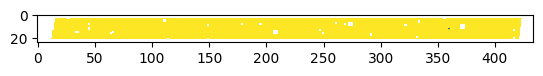

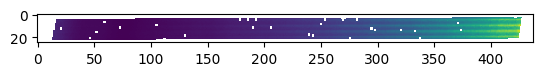

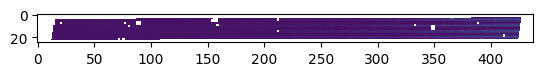

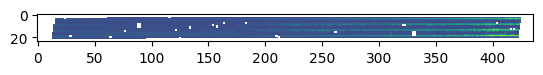

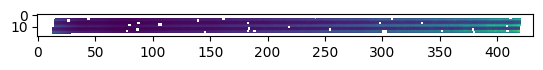

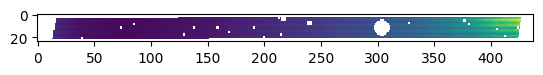

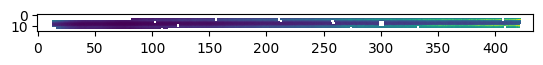

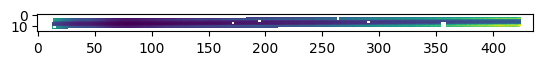

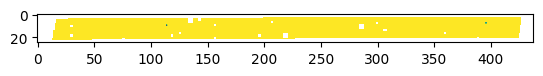

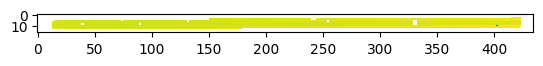

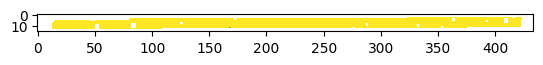

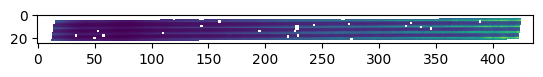

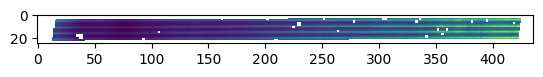

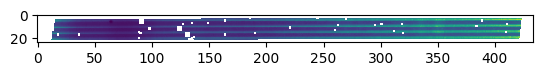

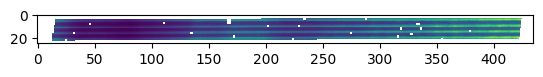

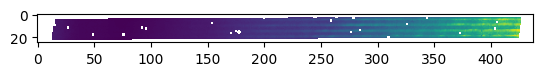

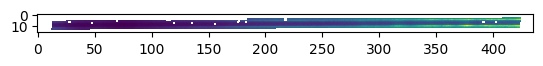

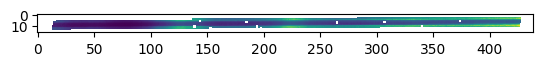

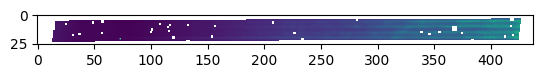

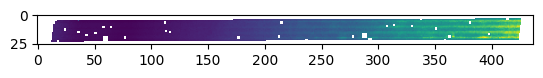

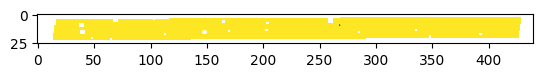

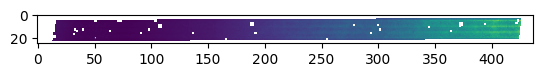

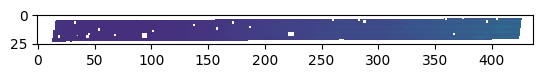

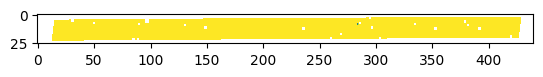

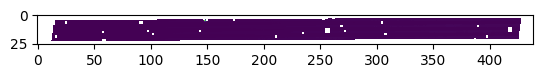

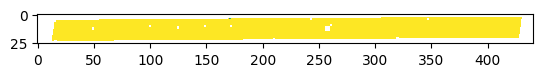

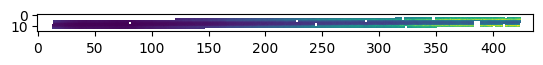

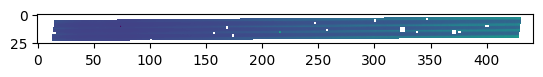

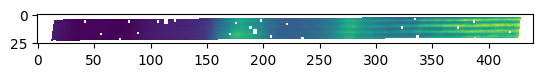

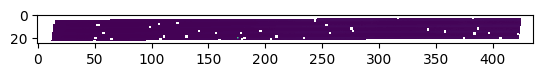

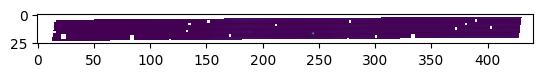

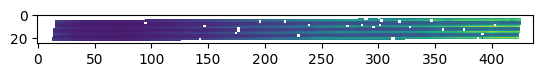

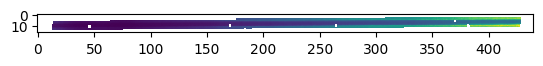

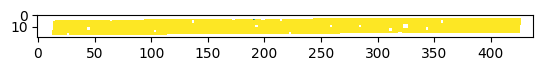

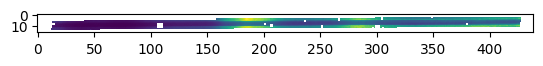

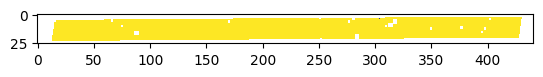

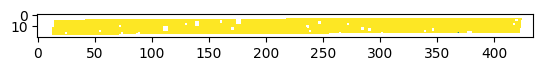

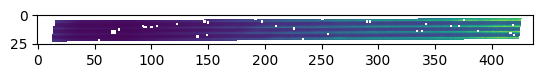

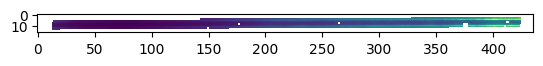

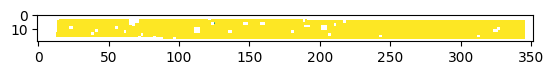

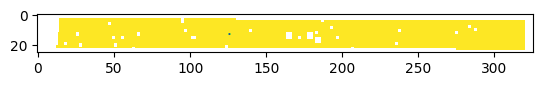

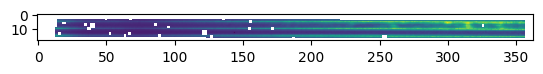

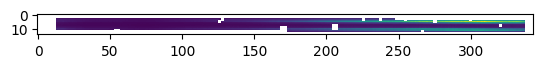

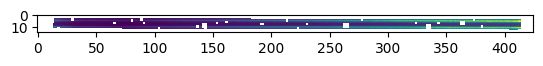

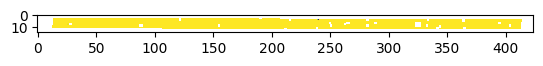

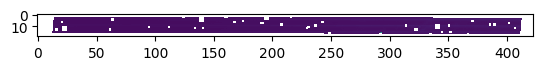

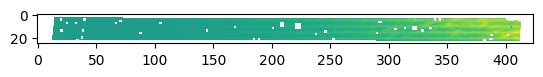

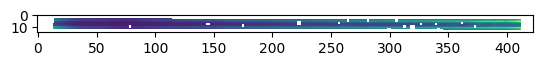

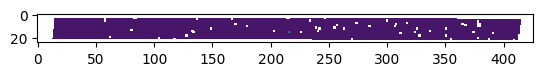

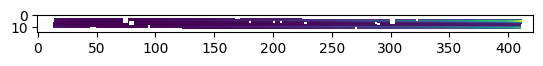

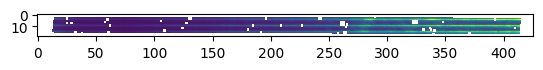

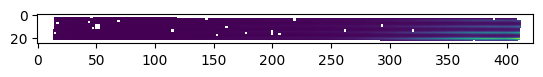

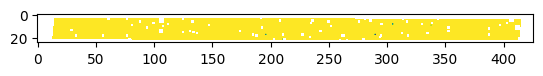

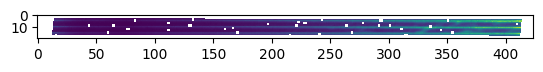

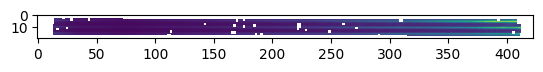

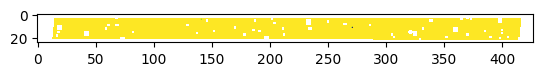

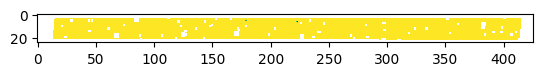

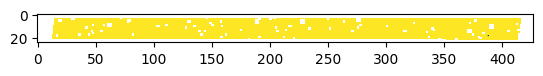

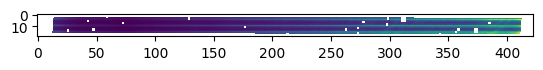

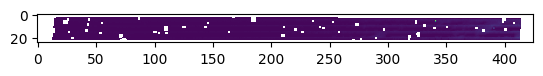

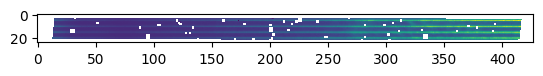

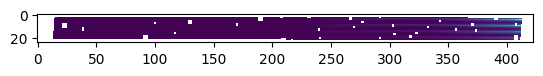

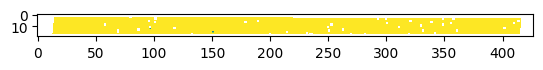

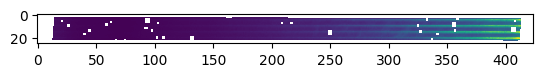

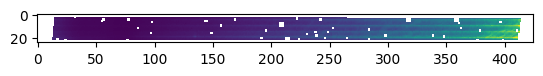

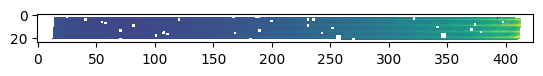

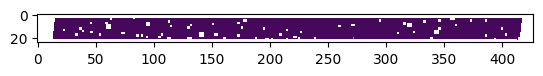

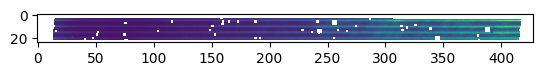

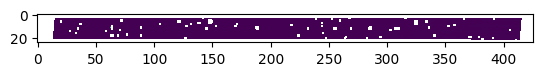

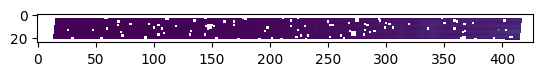

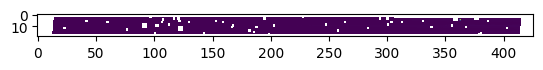

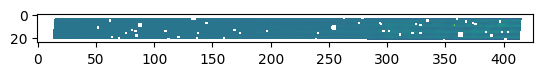

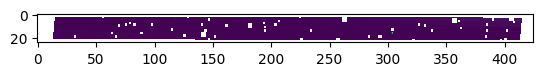

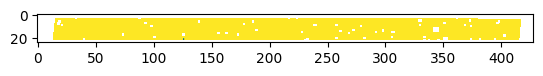

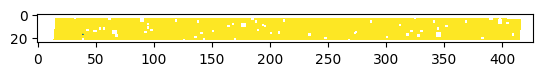

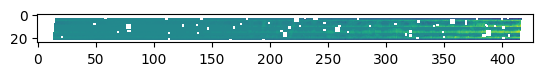

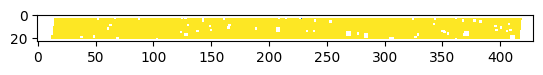

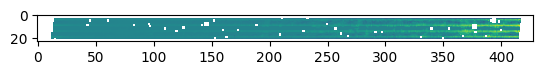

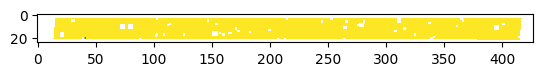

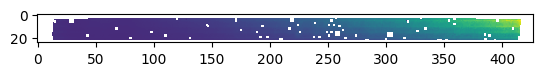

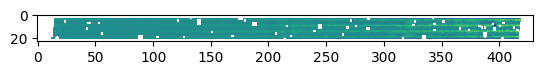

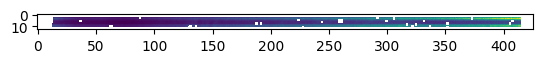

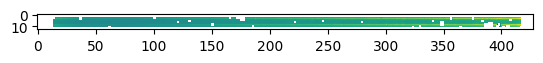

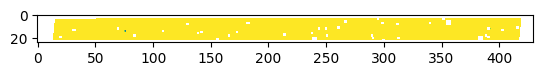

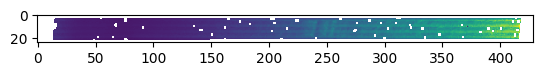

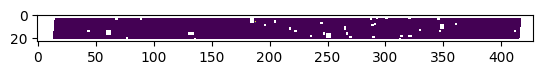

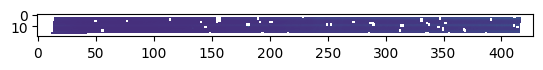

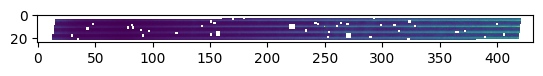

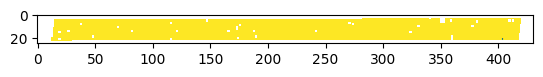

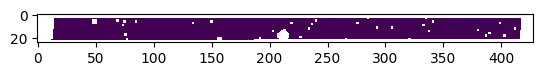

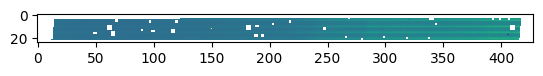

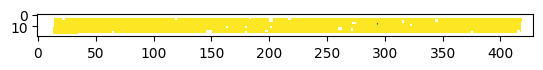

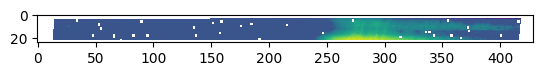

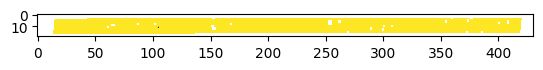

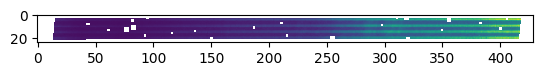

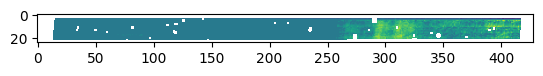

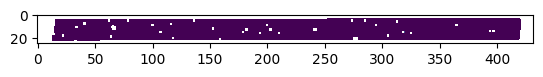

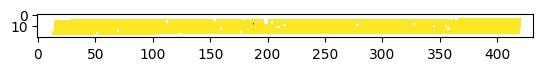

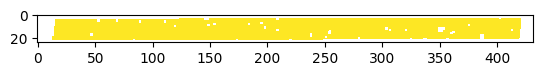

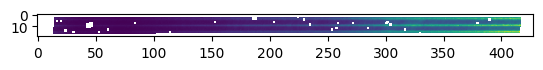

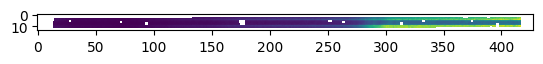

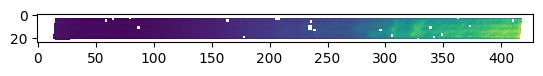

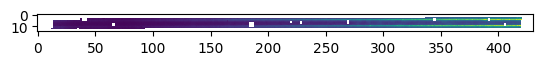

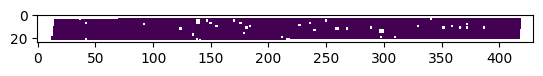

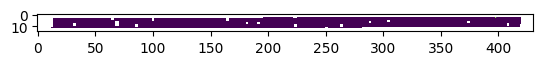

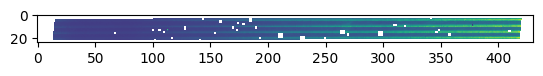

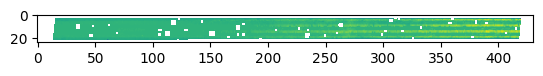

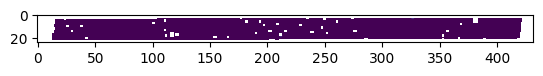

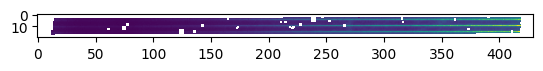

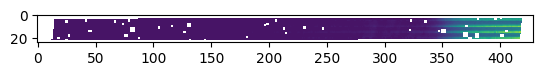

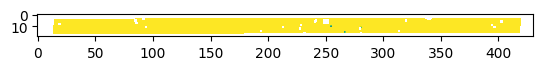

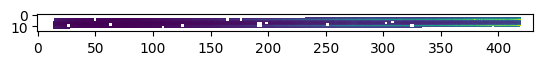

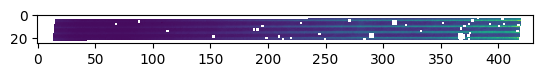

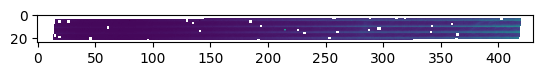

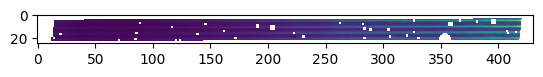

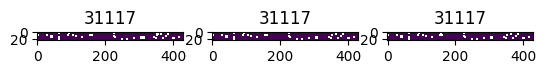

In [30]:
with fits.open("jw01345063001_03101_00001_nrs1_srctype.fits") as hdul2:
    with fits.open("jw01345063001_03101_00002_nrs1_srctype.fits") as hdul1:
        with fits.open("jw01345063001_03101_00003_nrs1_srctype.fits") as hdul3:
            n = 0
            for i,hdu in enumerate(hdul1):
                if not (hdu.name == "SCI"):
                    continue
                    
                hdr1 = hdu.header
                data1 = hdu.data
                hdr2 = hdul2[i].header
                data2 = hdul2[i].data
                hdr3 = hdul3[i].header
                data3 = hdul3[i].data
                
                if hdr1["SHUTSTA"] == 'x':
                    continue
                    
                srcid = 31117
                if not hdr1["SOURCEID"] == srcid and not hdr2["SOURCEID"] == srcid and not hdr3["SOURCEID"] == srcid:
                    continue

                if n > 10:
                    break
                n+=1

                
                

                plt.figure()
                plt.subplot(1,3,1)
                plt.imshow(data1)
                plt.title(hdr1["SOURCEID"])
                plt.subplot(1,3,2)
                plt.imshow(data2)
                plt.title(hdr2["SOURCEID"])
                plt.subplot(1,3,3)
                plt.imshow(data3)
                plt.title(hdr3["SOURCEID"])
                plt.show()